## Linear Regression as a model of Emotional Appraisal

The first example we discuss involves building a simple linear regression model in Pyro. We consider a case that is relevant to affective computing --- how should we build a model to reason about someone's emotions? There are lots of emotion theories that one can draw from, and probabilistic programming offers an elegant way to specify (and test!) these theories.


Before we jump in, we want to introduce the dataset that we'll be working with throughout the rest of the tutorial. This dataset is of a managable size (so training shouldn't take too long), but still complex enough that we can demonstrate some of the nice features of applying probabilistic programming to model real-life, AI-relevant examples (in this case, relevant to affective computing).

### Dataset

We will be using data from a published paper (Ong, Zaki, & Goodman, 2015; Experiment 3), which is available [here](https://github.com/desmond-ong/affCog) but we have also reproduced the data in the current repository. In this experiment, we showed human participants an agent playing a gamble; he spins a wheel with three possible outcomes, and wins the amount on the wheel. 

<div style="width: 500px; margin: auto;">![Experiment Summary](images/experimentSummary.png)</div>
(Figure modified from Ong et al, 2015, Figure 9).

On some trials, participants see the outcome that the agent won ((i) above). On other trials ((ii) above), participants were not shown the outcome, but instead were shown what ostensibly was the agent's facial expression after seeing the outcome. And on the last third of trials ((iii) above), participants were shown both the outcome and the agent's facial expression.
Following these, participants were asked to rate how they thought the agent felt, on 8 emotions, using a 9 point Likert scale.

Thus, the dataset consists of some "outcome only" trials where participants saw outcomes and rated the agent's emotions, "facial expression only" trials where participants attributed emotions to a facial expression, and trials where they saw both and had to integrate the information from both the outcome and the facial expression to make a judgment.

### Appraising the outcome

Let us first consider the "outcome only" trials. Many established emotion theories and affective computing theories hold that people experiencing events (e.g., winning the lottery, missing the bus) will evaluate the situation according to a set of important features. Was the outcome desirable? Was the outcome surprising? Was the outcome controllable? This evaluation is known as **appraisal**.

Put another way, the number of situations that people encounter in daily life vary immensely along a large number of dimensions, some important (the amount that one wins in the lottery) and some not so important (the color of the lottery ticket). **Appraisal** is computationally necessary to reduce the complexities of everyday situations into a low dimensional set of emotion-relevant dimensions.


### A Linear Regression model with Appraisal

Thus, we already have the few basic ingreidents of our theory. We have an observable variable (the outcome). We have an appraisal process that converts the outcome into a small number of relevant features. And we have the emotion ratings that people produce. Let's construct a basic regression model:

<div style="width: 300px; margin: auto;">![Graphical Model](images/graphicalModel_LinearRegression.png)</div>

Here's how to read the model above, which uses graphical mdoel notation. Shaded circles represent observed variables, while unshaded represents latent, or unobserved variables. Small rectangles represent parameters (to be fitted). We have $N$ pairs of (*Outcome*, *Emotion Ratings*), where $N$ is the size of the dataset, and so these are represented in the large rectangle (called a "plate"), to indicate that they are repeated $N$ times. And between these *Outcome* and *Rating* pairs, we have an appraisal transformation.

In a linear regression, we have beta weights that map the appraisal to the emotion ratings. If the appraisal variables are given by $\{1, a_1, a_2, \ldots, a_I\} = \vec{a}$, we can write an equation like: 

*Rating* = $\vec{\beta} \cdot \vec{a}$ = $\beta_0$ + $\beta_1 a_1$ + $\beta_2 a_2$ + $\ldots$ + $\beta_I a_I$ + $\epsilon$

where the $\beta_i$s represent the regression weights for the $i$-th appraisal variable, $\beta_0$ is the bias term and $\epsilon$ is an error term. Notice that the $\beta_i$s should remain the same across all $N$ observations: thus, it is left out of the "plate" in the model diagram above.

We assume that each $\beta_i$ is drawn from a Normal distribution parameterized by a mean (location parameter) $\mu_i$ and a standard deviation (or scale parameter) $\sigma_i$. I.e., $\beta_i \sim N(\mu_i, \sigma_i)$. We wish to learn these parameters $\mu_i, \sigma_i$ from the data.


(Note: Appraisal in this model is a strange creature. We could represent it as a latent variable (so like *outcome*, but unshaded). Here, to reflect the fact that appraisal is a modular function that can be tested scientifically against data, we chose to represent it more like a fittable parameter.).

Let's write some Pyro!

##### Preamble

This first chunk of code imports the necessary python packages and functions that we will use

In [1]:
from __future__ import division, print_function, absolute_import

%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import pyro
import pyro.distributions as dist
from pyro.distributions import Normal
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

This next chunk defines some variable and names that are specific to this dataset, as well as a function to read in the data.

The data is stored in `outcome_emotion_dataset`, which is a torch Tensor of size (1541, 17), indicating that there are N=1,541 observations of 17 variables. The first 9 are the parameterization of the outcome (the 3 payoffs on the wheel and their probabilities, which outcome they won and that probability, and the angle within the sector that the wheel landed on), and the next 8 are the emotion variables. All the variables are scaled so that they lie within [0,1].

In [2]:
# data location
dataset_path = os.path.join(os.path.abspath('..'), "CognitionData", "data_wheelOnly.csv")

OUTCOME_VAR_NAMES = ["payoff1", "payoff2", "payoff3", "prob1", "prob2", "prob3", "win", "winProb", "angleProp"]
EMOTION_VAR_NAMES = ["happy", "sad", "anger", "surprise", "disgust", "fear", "content", "disapp"]
OUTCOME_VAR_DIM = len(OUTCOME_VAR_NAMES)
EMOTION_VAR_DIM = len(EMOTION_VAR_NAMES)

def load_outcome_emotion_dataset(csv_file, normalize_values=True):
    data_readin = pd.read_csv(csv_file)
    outcome_data = data_readin.loc[:,OUTCOME_VAR_NAMES]
    if normalize_values:
        ####
        ## payoff1, payoff2, payoff3 and win are between 0 and 100
        ## need to normalize to [0,1] to match the rest of the variables,
        ## by dividing payoff1, payoff2, payoff3 and win by 100
        ####
        outcome_data.loc[:,"payoff1"] = outcome_data.loc[:,"payoff1"]/100
        outcome_data.loc[:,"payoff2"] = outcome_data.loc[:,"payoff2"]/100
        outcome_data.loc[:,"payoff3"] = outcome_data.loc[:,"payoff3"]/100
        outcome_data.loc[:,"win"]     = outcome_data.loc[:,"win"]/100
    outcome_data = torch.tensor(outcome_data.values).type(torch.Tensor)
    
    # the actual data has 8 emotions, but for illustration we just use 1 emotion, happy
    # the rest of the functions below assume a 1-D "y" variable
    emotion_data = data_readin.loc[:,EMOTION_VAR_NAMES]
    #emotion_data = data_readin.loc[:, "happy"]
    if normalize_values:
        ## note that emotions are transformed from a 9 point Likert to [0,1] via emo <- (emo-1)/8
        emotion_data   = (emotion_data-1)/8
    #emotion_data = emotion_data.values.reshape( emotion_data.shape[0] , 1)
    #emotion_data = torch.tensor(emotion_data).type(torch.Tensor)
    emotion_data = torch.tensor(emotion_data.values).type(torch.Tensor)
    
    data = torch.cat((outcome_data, emotion_data), 1)
    return data


# reads in datafile
outcome_emotion_dataset = load_outcome_emotion_dataset(csv_file=dataset_path)
N_samples = outcome_emotion_dataset.shape[0]

print(outcome_emotion_dataset.shape)

torch.Size([1541, 17])


`compute_appraisal()` is a function that takes in an outcome vector, and returns a vector of appraisal values. The example below reproduces the appraisal function used in Ong et al (2015). But more generally, this is a modular function that can be substituted out to test other possible operationalizations of appraisal theories.

In [3]:
def compute_appraisal(outcome_data):
    # We have a simple hard-coded these appraisals, for illustration
    # This is following Ong, Zaki, & Goodman (2015)
    # the outcome data columns are, in order:
    # ["payoff1", "payoff2", "payoff3", "prob1", "prob2", "prob3", "win", "winProb", "angleProp"]
    # the 3 appraisal variables are: 
    #     amount won ("win"),
    #     Prediction Error PE = win - EV, where EV = prob1*payoff1 + prob2*payoff2 + prob3*payoff3
    #     absolute value of PE
    
    # if outcome_data only has 1 observation, reshape so vectorization works
    if(len(outcome_data.shape)==1):
        outcome_data = outcome_data.view(1,9)
        print(outcome_data.shape)
    
    # initializing appraisalVals
    appraisalVals = torch.zeros(size=(outcome_data.shape[0],3))
    appraisalVals[:,0] = outcome_data[:,6] # amount won
    
    # Expected value
    EV = outcome_data[:,0] * outcome_data[:,3] + \
         outcome_data[:,1] * outcome_data[:,4] + \
         outcome_data[:,2] * outcome_data[:,5]
    
    # prediction error and absolute PE
    appraisalVals[:,1] = appraisalVals[:,0] - EV
    appraisalVals[:,2] = abs(appraisalVals[:,1])
    return(appraisalVals)


This is the model. Let's break down what goes on.

First, the model samples some $\beta$ coefficients from a Normal with some priors over the mean and the scale (in this case, mean of 0 and scale of 1).
This is achieved using the `pyro.sample()` function. 
For example,

`b_0 = pyro.sample("b_0", Normal(coeff_mean_prior, coeff_scale_prior))`


Note that the `sample()` function takes in a variable name, which allows Pyro to uniquely identify that variable in its variable store. (As such, the variable names are unique, and you can only have one `sample()` function with a particular variable name in this function).



Next, the function will loop over the observed data, using `pyro.iarange()`. This function defines a special Pyro environment with a unique name (`"map"`), within which Pyro understands that each iteration of the "loop" is conditionally independent. Thus, the computation on each data-point is conditionally independent from the computation on other data-points. (This reflects the plate-notation in the model above; each datapoint is independent, BUT the $\beta$ coefficients are the same across all of them, that's why they were defined before the `pyro.iarange()` loop)

Within this loop, we take the `outcome_data`, run it through `compute_appraisal()` to get a small 3-dimensional `appraisal_vars`. We manually compute the regression equation:

`prediction = b_0 + b_1 * appraisal_vars[:,0] + b_2 * appraisal_vars[:,1] + b_3 * appraisal_vars[:,2]`

Thus, `prediction` is the mean of the Normal distribution that the linear regression model predicts.
Finally, we condition on the observed data:

`pyro.sample("obs", Normal(prediction, 1), obs = emotion_data)`

Notice we use `pyro.sample()` again. We draw a sample from a Normal with mean `prediction` and scale 1, but this time, we condition that this sample is equal to the observed `emotion_data`, using the argument `obs = ...`.


And that's basically it for this function. Pyro's `irange()` and `iarange()` [functions](http://pyro.ai/examples/svi_part_ii.html#iarange) allow a flexible way to perform computations on individual datapoints while taking care of conditional independencies (the `i` in `irange()` and `iarange()`). One difference is that `iarange()` is vectorized, so we can perform the calculations on the entire data Tensor instead of individual observations.



In [4]:
def fit_regression_model(data):
    # define the parameters that control the gaussian prior over the regression coeffs.
    # mean = 0, scale = 1
    coeff_mean_prior = torch.tensor(0.0)
    coeff_scale_prior = torch.tensor(1.0)
    
    # sample b_0 (intercept) and b_1 to b_3 (regression coeffs)
    b_0 = pyro.sample("b_0", Normal(coeff_mean_prior, coeff_scale_prior))
    b_1 = pyro.sample("b_1", Normal(coeff_mean_prior, coeff_scale_prior))
    b_2 = pyro.sample("b_2", Normal(coeff_mean_prior, coeff_scale_prior))
    b_3 = pyro.sample("b_3", Normal(coeff_mean_prior, coeff_scale_prior))
    
    # loop over observed data
    with pyro.iarange("map", data.shape[0]):
        outcome_data = data[:, :(OUTCOME_VAR_DIM)]
        # Here, for simplification, we are only taking one emotion variable (happy)
        # instead of all 8.
        emotion_data = data[:, OUTCOME_VAR_DIM]  
        appraisal_vars = compute_appraisal(outcome_data)
        
        # run the regression forward
        prediction = b_0 + b_1 * appraisal_vars[:,0] + b_2 * appraisal_vars[:,1] + b_3 * appraisal_vars[:,2]
        # condition on the observed data
        pyro.sample("obs", Normal(prediction, 1), obs = emotion_data)

todo: talk about guide

In [5]:
def fit_regression_guide(data):
    coeff_mean_b0  = pyro.param("coeff_mean_b0",  torch.tensor(0.0))
    coeff_scale_b0 = pyro.param("coeff_scale_b0", torch.tensor(1.0))
    coeff_mean_b1  = pyro.param("coeff_mean_b1",  torch.tensor(0.0))
    coeff_scale_b1 = pyro.param("coeff_scale_b1", torch.tensor(1.0))
    coeff_mean_b2  = pyro.param("coeff_mean_b2",  torch.tensor(0.0))
    coeff_scale_b2 = pyro.param("coeff_scale_b2", torch.tensor(1.0))
    coeff_mean_b3  = pyro.param("coeff_mean_b3",  torch.tensor(0.0))
    coeff_scale_b3 = pyro.param("coeff_scale_b3", torch.tensor(1.0))
    # sample coefficients from Normal(mean, scale)
    pyro.sample("b_0", Normal(coeff_mean_b0, coeff_scale_b0))
    pyro.sample("b_1", Normal(coeff_mean_b1, coeff_scale_b1))
    pyro.sample("b_2", Normal(coeff_mean_b2, coeff_scale_b2))
    pyro.sample("b_3", Normal(coeff_mean_b3, coeff_scale_b3))

Next, we can proceed to actually fit the model. The first step is to refresh the parameter store using `pyro.clear_param_store()`.

We will use Stochastic Variational Inference `SVI()` which takes in the model and guide that we wrote above, as well as an optimization algorithm (here we use `torch.optim.Adam()`) and a loss function (here we use `Trace_ELBO()`). When `svi.step(data)` is called, it runs SVI over the `data`. Thus, here we simply define a loop that runs over the entire dataset `num_iterations` times. (We can easily modify this to do mini-batching, for example, for large datasets.)

[iteration 0001] loss: 2.3637
[iteration 0101] loss: 1.3586
[iteration 0201] loss: 0.9622
[iteration 0301] loss: 0.9521
[iteration 0401] loss: 0.9502
[iteration 0501] loss: 0.9407
[iteration 0601] loss: 0.9445
[iteration 0701] loss: 0.9491
[iteration 0801] loss: 0.9429
[iteration 0901] loss: 0.9464


Text(0,0.5,'loss')

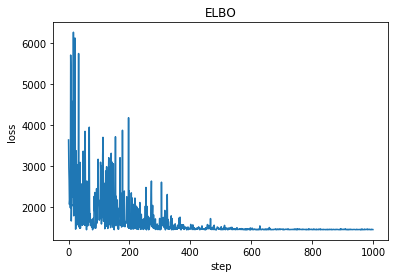

In [7]:
pyro.clear_param_store()

num_iterations = 1000

# setup the optimizer with some learning rate
optimizer = Adam({"lr": 0.005})

# setup the inference algorithm
svi = SVI(fit_regression_model, fit_regression_guide, optimizer, loss=Trace_ELBO())

# do gradient steps
losses = []
for thisIteration in range(num_iterations):
    # calculate the loss and take a gradient step
    thisLoss = svi.step(outcome_emotion_dataset)
    losses.append(thisLoss)
    if thisIteration % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (thisIteration + 1, thisLoss / float(N_samples)))

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")


In [8]:
# output the learned variational parameters
learnt_params = [pyro.param("coeff_mean_b0").item(), pyro.param("coeff_scale_b0").item(),
                 pyro.param("coeff_mean_b1").item(), pyro.param("coeff_scale_b1").item(),
                 pyro.param("coeff_mean_b2").item(), pyro.param("coeff_scale_b2").item(),
                 pyro.param("coeff_mean_b3").item(), pyro.param("coeff_scale_b3").item()]
print(learnt_params)

[0.3255805969238281, 0.02385237067937851, 0.48056650161743164, 0.041164662688970566, 0.651533305644989, 0.11297078430652618, 0.08928068727254868, 0.19496673345565796]


todo: Discuss

todo: Bayesian Regression